In [5]:
import numpy as np
from utils import oned_well, functions
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import math

In [6]:
generations = 10000
generation_size = 10000
n_best = 100
n_variables = 25
well_length = 5
dead_iter_max = 1000

# ! TODO: añadir sampleo para variables continuas que tenga en cuenta span(x)/dim(x)
# TODO: reject elite if mean score goes up?
# TODO: añadir un módulo de interpolación de una función analítica con los puntos de x
# TODO: añadir visualización de la pérdida
# TODO: mejorar la aproximación de la integral (triángulos? montecarlo?), segmentándola en el proceso
# TODO: sampleo uniforme de muestras entre [mu+n*sigma, mu-n*sigma]?
# TODO: por que se estropea para muchos puntos :(((
# Initialization
population = np.random.random([generation_size, n_variables])
generation_mean = 0
generation_std = 3
mean_elite_scores = []
elite_stds = []


def generate_normal_population(mean, std, size):
    return np.random.normal(mean, std, size)


def generate_uniform_population(mean, std, size, factor=10):
    # top_lim = mean + factor * std
    # bottom_lim = mean - factor * std
    # assert all(top_lim > bottom_lim)
    # return np.random.uniform(bottom_lim, top_lim, size)
    size[0] = size[0] * 10
    return np.random.normal(mean, factor * std, size)


def generate_coherent_population(elite_std, mean, std, size, factor):
    if elite_std > 0.01:
        return generate_normal_population(mean, std, size)
    else:
        return generate_uniform_population(mean, std, size, factor)


# TODO: estudiar mejor el efecto del factor en el sampleo para aumentar la búsqueda cuando converge la población

best_mean_elite_score = 1e20
# Generation loop
with alive_bar(
    0, force_tty=True, bar=None, theme="scuba", stats=False, stats_end=False
) as bar:
    for generation in range(generations):
        # scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
        scores = functions.parallel_apply_along_axis(
            oned_well.compute_z_triangles, 1, population
        )
        # max_scores_index = np.argpartition(scores, -n_best)[-n_best:] # (si fuese maximizar)
        min_scores_index = np.argpartition(scores, n_best)[:n_best]
        best_individuals = population[min_scores_index]
        mean_elite_score = scores[min_scores_index].mean()

        # Optimization guarantee
        if mean_elite_score < best_mean_elite_score - 0.01:
            # Si la media disminuye, se actualiza la población
            generation_mean = best_individuals.transpose().mean(axis=1)
            generation_std = best_individuals.transpose().std(axis=1)
            elite_std = generation_std.max()
            best_mean_elite_score = mean_elite_score
            # population = generate_coherent_population(
            #     elite_std,
            #     generation_mean,
            #     generation_std,
            #     [generation_size, n_variables],
            # )
            population = generate_normal_population(
                generation_mean,
                generation_std,
                [generation_size, n_variables],
            )
            # TODO: guardar el index
            best_elite = best_individuals
            dead_iter = 0
        else:
            dead_iter += 1
            # TODO: ir ampliando el rango de búsqueda
            if dead_iter > dead_iter_max:
                break
            # Si la media empeora, se repite el sampleo
            # population = generate_coherent_population(
            #     elite_std,
            #     generation_mean,
            #     generation_std,
            #     [generation_size, n_variables],
            #     factor=dead_iter**2,
            # )
            factor = math.floor(dead_iter / 10) + 1
            population = generate_uniform_population(
                generation_mean,
                generation_std,
                [generation_size, n_variables],
                factor=factor,
            )
        bar()
        bar.text(
            "- elite mean: {:.2e}, elite std: {:.2e}, dead: {}".format(
                best_mean_elite_score, elite_std, dead_iter
            )
        )
        mean_elite_scores.append(mean_elite_score)
        elite_stds.append(elite_std)
print(
    "elite mean: {:.2e}, elite std: {:.2e}, dead: {}".format(
        best_mean_elite_score, elite_std, dead_iter
    )
)

1014 in 8:14.3                                                                  
elite mean: 7.05e-02, elite std: 2.00e-02, dead: 1001


In [ ]:
# generations = 100
# generation_size = 10000
# n_best = 100
# n_variables = 25
# well_length = 5
# convergence_threshold = 1e-6

# # ! TODO: añadir sampleo para variables continuas que tenga en cuenta span(x)/dim(x)
# # TODO: reject elite if mean score goes up?
# # TODO: añadir un módulo de interpolación de una función analítica con los puntos de x
# # TODO: añadir visualización de la pérdida
# # TODO: mejorar la aproximación de la integral (triángulos? montecarlo?), segmentándola en el proceso
# # TODO: sampleo uniforme de muestras entre [mu+n*sigma, mu-n*sigma]?
# # TODO: por que se estropea para muchos puntos :(((
# # Initialization
# population = np.random.random([generation_size, n_variables])
# mean_elite_scores = []
# elite_stds = []


# def generate_normal_population(mean, std, size):
#     return np.random.normal(mean, std, size)


# def generate_uniform_population(mean, std, size):
#     # top_lim = mean + 3 * std
#     # bottom_lim = mean - 3 * std
#     # assert all(top_lim > bottom_lim)
#     # return np.random.uniform(bottom_lim, top_lim, size)
#     return np.random.normal(mean, 10 * std, size)


# def generate_coherent_population(elite_std, mean, std, size):
#     if elite_std > 0.01:
#         return generate_normal_population(mean, std, size)
#     else:
#         return generate_uniform_population(mean, std, size)


# last_mean_elite_score = 1e20
# # Generation loop
# with alive_bar(
#     0, force_tty=True, bar=None, theme="scuba", stats=False, stats_end=False
# ) as bar:
#     for generation in range(generations):
#         bar()
#         # scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
#         scores = functions.parallel_apply_along_axis(
#             oned_well.compute_z_triangles, 1, population
#         )
#         # max_scores_index = np.argpartition(scores, -n_best)[-n_best:] # (si fuese maximizar)
#         min_scores_index = np.argpartition(scores, n_best)[:n_best]
#         best_individuals = population[min_scores_index]
#         best_individuals_mean = best_individuals.transpose().mean(axis=1)
#         best_individuals_std = best_individuals.transpose().std(axis=1)
#         mean_elite_score = scores[min_scores_index].mean()
#         elite_std = best_individuals_std.max()
#         bar.text(
#             "- elite mean score: {:.5g}, elite std: {:.5g}".format(
#                 mean_elite_score, elite_std
#             )
#         )
#         mean_elite_scores.append(mean_elite_score)
#         elite_stds.append(elite_std)

#         if elite_std < convergence_threshold:
#             population = best_individuals
#             break
#         else:
#             population = np.random.normal(
#                 best_individuals_mean,
#                 best_individuals_std,
#                 [generation_size, n_variables],
#             )

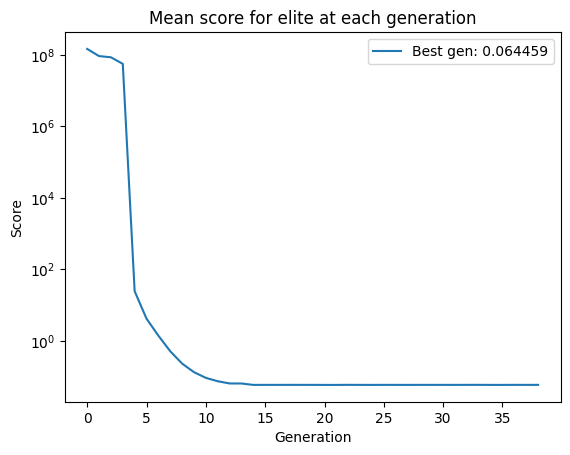

In [ ]:
plt.plot(
    mean_elite_scores,
    label="Best gen: {:.5g}".format(best_mean_elite_score),
)
plt.title("Mean score for elite at each generation")
plt.xlabel("Generation")
plt.ylabel("Score")
plt.yscale("log")
plt.legend()

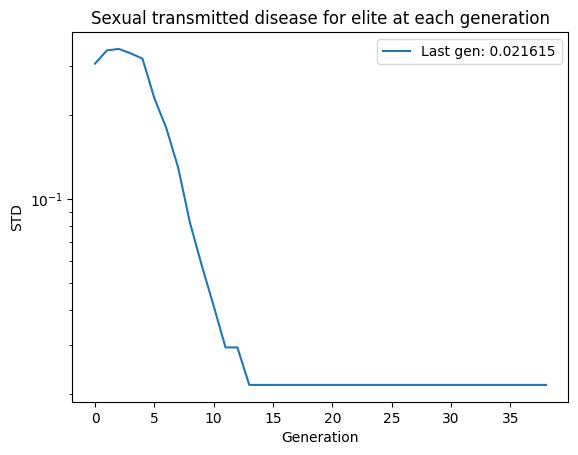

In [ ]:
plt.plot(elite_stds, label="Last gen: {:.5g}".format(elite_stds[-1]))
plt.title("Sexual transmitted disease for elite at each generation")
plt.xlabel("Generation")
plt.ylabel("STD")
plt.yscale("log")
plt.legend()

In [ ]:
# scores = np.apply_along_axis(oned_well.compute_z, 1, population) # Not parallel
scores = functions.parallel_apply_along_axis(
    oned_well.compute_z_triangles, 1, best_elite
)
best_score = min(scores)
best_individual = best_elite[np.argmin(scores)]
print(best_score)

0.06090651139389191


In [ ]:
def Psi_n(n):
    return (2 / well_length) ** 0.5 * np.sin(
        n * np.pi * np.linspace(0, well_length, n_variables) / well_length
    )


integral = 0
for i in range(len(best_individual)):
    integral = integral + (best_individual[i] ** 2) * (well_length / (n_variables - 1))

B = (1 / integral) ** 0.5
best_individual = B * best_individual

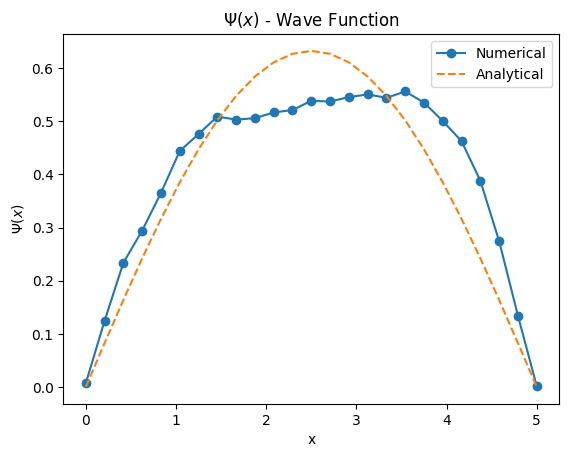

In [ ]:
plt.plot(np.linspace(0, 5, n_variables), best_individual, label="Numerical", marker="o")
plt.plot(np.linspace(0, 5, n_variables), Psi_n(1), "--", label="Analytical")
plt.gca().set_title("$\Psi(x)$ - Wave Function")
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("$\Psi(x)$")
plt.legend()